# Lab Assignment 2

**Submission deadline:**
* **Regular problems: last lab session before Friday, 6.11.20**
* **Bonus problems: deadline for Lab Assignment 3**

**Points: 12 + 3-6 bonus points**

Please note: some of the assignments are tedious or boring if you are already a NumPy ninja. The bonus problems were designed to give you a more satisfying alternative.

The assignment is in the form of a Jupyter notebook. We will be using [Google Colab](https://colab.research.google.com) to solve it. Below you will find a "Setup" section. Follow instructions from this paragraph to download the notebook and open it using [Google Colab](https://colab.research.google.com). 

Your goal is to solve problems posted below. Whenever possible, add your solutions to the notebook.

Please email us about any problems with it - we will try to correct them quickly. Also, please do not hesitate to use GitHub’s pull requests to send us corrections!

## Heads Up!

This assignment comes with starter code, but you are not forced to use it, as long as you execute all analysis demanded in the problems.

In [1]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport

In [1]:
# Standard IPython notebook imports
import itertools
import io
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as sopt
import scipy.stats as sstats
import seaborn as sns
import sklearn.ensemble
import sklearn.tree
from sklearn import datasets
from tqdm.auto import tqdm

import graphviz
import httpimport

# In this way we can import functions straight from github
with httpimport.github_repo(
    "janchorowski", "nn_assignments", module="common", branch="nn18"
):
    from common.gradients import check_gradient
    from common.plotting import plot_mat

sns.set_style("whitegrid")

# Problem 1 [2p] Naive Bayes Classifier

The Bayes' theorem allows us to construct a classifier in which we
model how the data is generated. Here we will describe a
simple and popular example of such a classifier called the naive
Bayes classifier.  Despite its simplicity It is quite effective for
classification of text documents (e.g. as spam and non-spam).

Let a document be a sequence of tokens, which usually are words, but can also be characters: $D=W_1,W_2,\ldots,W_n$ 
We will model generation of text documents as a two-stage process.
First, document category $C_j$ is drawn at random with probability
$p(C_j)$, also called the *a priori* probability.
To define the class-conditional probability
$p(D|C_j)$, we will make a simplifying (naive)
assumption, that every token in the document is drawn independently at
random with probability $p(W_i|C)$:

\begin{equation*}
p(D|C_j) = p(W_1,W_2,\ldots,W_n | C_j) \approx p(W_1|C_j)p(W_2|C_j)\ldots p(W_n|C_j).
\end{equation*}

To infer the class of a document we apply the Bayes theorem:
\begin{equation*}
p(C_j|D) = \frac{p(D|C_j)p(C_j)}{p(D)} = \frac{p(C_j)p(W_1|C_j)p(W_2|C_j)\ldots p(W_n|C_j)}{p(D)}.
\end{equation*}
Please note that since we assumed only a finite number of classes,
we can compute the term $p(D)$ by making sure that the *a
posteriori probabilities* $p(C_j|D)$ sum to $1$ over all classes.

In this exercise we will try to mimic the language-guessing feature
of [Google Translate](https://translate.google.com/), although
on a much smaller scale.  We are given an input which is a
lower-case sequence of characters (such as *"some people like
pineapple on their pizza"*), and we determine whether the
sequence's language is English, Polish or Spanish.
We will treat each character as a separate observation.
The numbers are taken from [Wikipedia article on letter frequency](https://en.wikipedia.org/wiki/Letter_frequency#Relative_frequencies_of_letters_in_other_languages). We display the first few rows:

In [2]:
wiki_table = u"""English|French|German|Spanish|Portuguese|Esperanto|Italian|Turkish|Swedish|Polish|Dutch|Danish|Icelandic|Finnish|Czech
a|8.167|7.636|6.516|11.525|14.634|12.117|11.745|12.920|9.383|10.503|7.486|6.025|10.110|12.217|8.421
b|1.492|0.901|1.886|2.215|1.043|0.980|0.927|2.844|1.535|1.740|1.584|2.000|1.043|0.281|0.822
c|2.782|3.260|2.732|4.019|3.882|0.776|4.501|1.463|1.486|3.895|1.242|0.565|0|0.281|0.740
d|4.253|3.669|5.076|5.010|4.992|3.044|3.736|5.206|4.702|3.725|5.933|5.858|1.575|1.043|3.475
e|12.702|14.715|16.396|12.181|12.570|8.995|11.792|9.912|10.149|7.352|18.91|15.453|6.418|7.968|7.562
f|2.228|1.066|1.656|0.692|1.023|1.037|1.153|0.461|2.027|0.143|0.805|2.406|3.013|0.194|0.084
g|2.015|0.866|3.009|1.768|1.303|1.171|1.644|1.253|2.862|1.731|3.403|4.077|4.241|0.392|0.092
h|6.094|0.737|4.577|0.703|0.781|0.384|0.636|1.212|2.090|1.015|2.380|1.621|1.871|1.851|1.356
i|6.966|7.529|6.550|6.247|6.186|10.012|10.143|9.600|5.817|8.328|6.499|6.000|7.578|10.817|6.073
j|0.153|0.613|0.268|0.493|0.397|3.501|0.011|0.034|0.614|1.836|1.46|0.730|1.144|2.042|1.433
k|0.772|0.049|1.417|0.011|0.015|4.163|0.009|5.683|3.140|2.753|2.248|3.395|3.314|4.973|2.894
l|4.025|5.456|3.437|4.967|2.779|6.104|6.510|5.922|5.275|2.564|3.568|5.229|4.532|5.761|3.802
m|2.406|2.968|2.534|3.157|4.738|2.994|2.512|3.752|3.471|2.515|2.213|3.237|4.041|3.202|2.446
n|6.749|7.095|9.776|6.712|4.446|7.955|6.883|7.987|8.542|6.237|10.032|7.240|7.711|8.826|6.468
o|7.507|5.796|2.594|8.683|9.735|8.779|9.832|2.976|4.482|6.667|6.063|4.636|2.166|5.614|6.695
p|1.929|2.521|0.670|2.510|2.523|2.755|3.056|0.886|1.839|2.445|1.57|1.756|0.789|1.842|1.906
q|0.095|1.362|0.018|0.877|1.204|0|0.505|0|0.020|0|0.009|0.007|0|0.013|0.001
r|5.987|6.693|7.003|6.871|6.530|5.914|6.367|7.722|8.431|5.243|6.411|8.956|8.581|2.872|4.799
s|6.327|7.948|7.270|7.977|6.805|6.092|4.981|3.014|6.590|5.224|3.73|5.805|5.630|7.862|5.212
t|9.056|7.244|6.154|4.632|4.336|5.276|5.623|3.314|7.691|2.475|6.79|6.862|4.953|8.750|5.727
u|2.758|6.311|4.166|2.927|3.639|3.183|3.011|3.235|1.919|2.062|1.99|1.979|4.562|5.008|2.160
v|0.978|1.838|0.846|1.138|1.575|1.904|2.097|0.959|2.415|0.012|2.85|2.332|2.437|2.250|5.344
w|2.360|0.074|1.921|0.017|0.037|0|0.033|0|0.142|5.813|1.52|0.069|0|0.094|0.016
x|0.150|0.427|0.034|0.215|0.253|0|0.003|0|0.159|0.004|0.036|0.028|0.046|0.031|0.027
y|1.974|0.128|0.039|1.008|0.006|0|0.020|3.336|0.708|3.206|0.035|0.698|0.900|1.745|1.043
z|0.074|0.326|1.134|0.467|0.470|0.494|1.181|1.500|0.070|4.852|1.39|0.034|0|0.051|1.503
à|0|0.486|0|0|0.072|0|0.635|0|0|0|0|0|0|0|0
â|0|0.051|0|0|0.562|0|0|0|0|0|0|0|0|0|0
á|0|0|0|0.502|0.118|0|0|0|0|0|0|0|1.799|0|0.867
å|0|0|0|0|0|0|0|0|1.338|0|0|1.190|0|0.003|0
ä|0|0|0.578|0|0|0|0|0|1.797|0|0|0|0|3.577|0
ã|0|0|0|0|0.733|0|0|0|0|0|0|0|0|0|0
ą|0|0|0|0|0|0|0|0|0|0.699|0|0|0|0|0
æ|0|0|0|0|0|0|0|0|0|0|0|0.872|0.867|0|0
œ|0|0.018|0|0|0|0|0|0|0|0|0|0|0|0|0
ç|0|0.085|0|0|0.530|0|0|1.156|0|0|0|0|0|0|0
ĉ|0|0|0|0|0|0.657|0|0|0|0|0|0|0|0|0
ć|0|0|0|0|0|0|0|0|0|0.743|0|0|0|0|0
č|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0.462
ď|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0.015
ð|0|0|0|0|0|0|0|0|0|0|0|0|4.393|0|0
è|0|0.271|0|0|0|0|0.263|0|0|0|0|0|0|0|0
é|0|1.504|0|0.433|0.337|0|0|0|0|0|0|0|0.647|0|0.633
ê|0|0.218|0|0|0.450|0|0|0|0|0|0|0|0|0|0
ë|0|0.008|0|0|0|0|0|0|0|0|0|0|0|0|0
ę|0|0|0|0|0|0|0|0|0|1.035|0|0|0|0|0
ě|0|0|0|0|0|0|0|0|0|0|0|0|0|0|1.222
ĝ|0|0|0|0|0|0.691|0|0|0|0|0|0|0|0|0
ğ|0|0|0|0|0|0|0|1.125|0|0|0|0|0|0|0
ĥ|0|0|0|0|0|0.022|0|0|0|0|0|0|0|0|0
î|0|0.045|0|0|0|0|0|0|0|0|0|0|0|0|0
ì|0|0|0|0|0|0|0.030|0|0|0|0|0|0|0|0
í|0|0|0|0.725|0.132|0|0|0|0|0|0|0|1.570|0|1.643
ï|0|0.005|0|0|0|0|0|0|0|0|0|0|0|0|0
ı|0|0|0|0|0|0|0|5.114|0|0|0|0|0|0|0
ĵ|0|0|0|0|0|0.055|0|0|0|0|0|0|0|0|0
ł|0|0|0|0|0|0|0|0|0|2.109|0|0|0|0|0
ñ|0|0|0|0.311|0|0|0|0|0|0|0|0|0|0|0
ń|0|0|0|0|0|0|0|0|0|0.362|0|0|0|0|0
ň|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0.007
ò|0|0|0|0|0|0|0.002|0|0|0|0|0|0|0|0
ö|0|0|0.443|0|0|0|0|0.777|1.305|0|0|0|0.777|0.444|0
ô|0|0.023|0|0|0.635|0|0|0|0|0|0|0|0|0|0
ó|0|0|0|0.827|0.296|0|0|0|0|1.141|0|0|0.994|0|0.024
õ|0|0|0|0|0.040|0|0|0|0|0|0|0|0|0|0
ø|0|0|0|0|0|0|0|0|0|0|0|0.939|0|0|0
ř|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0.380
ŝ|0|0|0|0|0|0.385|0|0|0|0|0|0|0|0|0
ş|0|0|0|0|0|0|0|1.780|0|0|0|0|0|0|0
ś|0|0|0|0|0|0|0|0|0|0.814|0|0|0|0|0
š|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0.688
ß|0|0|0.307|0|0|0|0|0|0|0|0|0|0|0|0
ť|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0.006
þ|0|0|0|0|0|0|0|0|0|0|0|0|1.455|0|0
ù|0|0.058|0|0|0|0|0.166|0|0|0|0|0|0|0|0
ú|0|0|0|0.168|0.207|0|0|0|0|0|0|0|0.613|0|0.045
û|0|0.060|0|0|0|0|0|0|0|0|0|0|0|0|0
ŭ|0|0|0|0|0|0.520|0|0|0|0|0|0|0|0|0
ü|0|0|0.995|0.012|0.026|0|0|1.854|0|0|0|0|0|0|0
ů|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0.204
ý|0|0|0|0|0|0|0|0|0|0|0|0|0.228|0|0.995
ź|0|0|0|0|0|0|0|0|0|0.078|0|0|0|0|0
ż|0|0|0|0|0|0|0|0|0|0.706|0|0|0|0|0
ž|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0.721"""
df = pd.read_table(io.StringIO(wiki_table), sep="|", index_col=0)
df.head()

,English,French,German,Spanish,Portuguese,Esperanto,Italian,Turkish,Swedish,Polish,Dutch,Danish,Icelandic,Finnish,Czech
a,8.167,7.636,6.516,11.525,14.634,12.117,11.745,12.920,9.383,10.503,7.486,6.025,10.110,12.217,8.421
b,1.492,0.901,1.886,2.215,1.043,0.980,0.927,2.844,1.535,1.740,1.584,2.000,1.043,0.281,0.822
c,2.782,3.260,2.732,4.019,3.882,0.776,4.501,1.463,1.486,3.895,1.242,0.565,0.000,0.281,0.740
d,4.253,3.669,5.076,5.010,4.992,3.044,3.736,5.206,4.702,3.725,5.933,5.858,1.575,1.043,3.475
e,12.702,14.715,16.396,12.181,12.570,8.995,11.792,9.912,10.149,7.352,18.910,15.453,6.418,7.968,7.562


Implement the language classifier and answer the following:

1. **[0.5p]** Naive Bayes can be implemented
    either by multiplying probabilities or by adding
    log-probabilities. Which one is better and why?

    Please type a short answer below.
2. **[1.5p]** What is the language of the following phrases, according to the Naive Bayes classifier (whihc you have to implement in a code cell below)? Assume equal prior language probabilities $P(C)$.

Using log-probabilities is **better** because:
- if the product of probabilities is very small it may accidentally get rounded to zero("underflow")
- multiplication is slower than addition (complexity)

In [3]:
# We can easily manipulate the letter frequency table using Pandas
langs = list(df)
letters = list(df.index)
print("Languages:", ",".join(langs))
print("Letters:", ", ".join(letters))
print("P(ę|Polish) =", df.loc["ę", "Polish"])

Languages: English,French,German,Spanish,Portuguese,Esperanto,Italian,Turkish,Swedish,Polish,Dutch,Danish,Icelandic,Finnish,Czech
Letters: a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y, z, à, â, á, å, ä, ã, ą, æ, œ, ç, ĉ, ć, č, ď, ð, è, é, ê, ë, ę, ě, ĝ, ğ, ĥ, î, ì, í, ï, ı, ĵ, ł, ñ, ń, ň, ò, ö, ô, ó, õ, ø, ř, ŝ, ş, ś, š, ß, ť, þ, ù, ú, û, ŭ, ü, ů, ý, ź, ż, ž
P(ę|Polish) = 1.035


In [4]:
# The values are percentages of letter appearance, but curiously enough they don't
# sum to 100%.
print(f"\nTotal letter count by language:\n{df.sum(0)}")

# Thus we normalize the data such that the letter frequencies add up to 1 for each language
df_norm = df.apply(lambda x: x / np.sum(x), axis = 0)
print(f"\nAfter normalization:\n{df_norm.sum(0)}")


Total letter count by language:
English        99.999
French        100.060
German        100.002
Spanish       100.000
Portuguese    100.040
Esperanto      99.960
Italian       100.007
Turkish       106.997
Swedish        99.999
Polish        100.027
Dutch         100.157
Danish         99.999
Icelandic      99.998
Finnish       100.004
Czech          88.013
dtype: float64

After normalization:
English       1.0
French        1.0
German        1.0
Spanish       1.0
Portuguese    1.0
Esperanto     1.0
Italian       1.0
Turkish       1.0
Swedish       1.0
Polish        1.0
Dutch         1.0
Danish        1.0
Icelandic     1.0
Finnish       1.0
Czech         1.0
dtype: float64


In [5]:
def naive_bayes(sent, langs, df):
    """Returns the most probable language of a sentence"""

    # Try working with log-probabilities.
    # to prevent taking log(0) you can e.g. add a very small amount (1e-100)
    # to each tabulated frequency.
    df_log = df.apply(lambda x: np.log(x + 1e-100), axis = 0)

    # normalize the sentence: remove spaces and punctuations, take lower case
    sent = ''.join(char for char in sent.lower() if char in list(df.index))

    log_probs = {}
    
    #set a prior probability (equal for all languages)
    prior = np.log(1 / len(langs))
    
    for lang in langs:
        
        to_be_summed = [df_log.loc[char, lang] for char in sent]
        
        log_probs[lang] = np.exp(prior + sum(to_be_summed)) #convert to regular probabilities
        
    #calculate normalization constant using sum(cond. prob.) = 1
    z = sum(log_probs.values())
    
    #TODO compute language probabilities and order from most to least probable
    probs = {k: v/z for k, v in sorted(log_probs.items(), key=lambda item: item[1], reverse=True)}
    
    return probs


In [6]:
sentences = [
    "No dejes para mañana lo que puedas hacer hoy.",
    "Przed wyruszeniem w drogę należy zebrać drużynę.",
    "Żeby zrozumieć rekurencję, należy najpierw zrozumieć rekurencję.",
    "Si vale la pena hacerlo vale la pena hacerlo bien.",
    "Experience is what you get when you didn't get what you wanted.",
    "Należy prowokować intelekt, nie intelektualistów.",
]


for sent in sentences:
    print(f"{sent}:")
    for k, v in naive_bayes(sent, langs, df_norm).items():
        if v < 1e-3:
            break
        print(f"{k}: {v:.3f}\t", end="")
    print("\n")


No dejes para mañana lo que puedas hacer hoy.:
Spanish: 1.000	

Przed wyruszeniem w drogę należy zebrać drużynę.:
Polish: 1.000	

Żeby zrozumieć rekurencję, należy najpierw zrozumieć rekurencję.:
Polish: 1.000	

Si vale la pena hacerlo vale la pena hacerlo bien.:
Italian: 0.925	Spanish: 0.047	English: 0.007	French: 0.006	Dutch: 0.006	Swedish: 0.004	Portuguese: 0.003	Esperanto: 0.001	

Experience is what you get when you didn't get what you wanted.:
English: 1.000	

Należy prowokować intelekt, nie intelektualistów.:
Polish: 1.000	



# Problem 2 [3p] Ridge Regression

In this problem you will implement ridge regression **without using `sklearn`**!

When the data set is small and highly dimensional (or when high degree polynomials are used) the linear regression solution may fit the noise in the data instead of capturing the general rule. We call this phenomenon overfitting and will discuss it in detail in a few lectures.

One way of preventing overfitting is to force the model's parameters to be small. We call this *regularization*. Consider the following cost function:

$$ J(\Theta) = \frac{1}{N}\sum_{i=1}^N (y^{(i)} - x^{(i)}\Theta)^2 + \frac{\alpha}{N} \Theta^T \Theta $$

Analyze datasets sampled using the following procedure:

1. $x \propto U(0;1)$: first $x$ is sampled uniformly from the  $0-1$ range.
2. $y \propto \mathcal{N}(\mu=1+2x-5x^2 + 4x^3, \sigma=0.1)$: then 
    $y$ is sampled from the Normal distribution with mean 
    $\mu=1+2x-5x^2+4x^3$ and standard deviation $0.1$


## Task 2.1 [1.5p]
Repeat 30 times an experiment in which you sample a new training
dataset, then fit polynomials of degree 0 to 14 and use $\alpha$
value from the set $\{0, 10^{-6}, 10^{-5}, 10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}\}$.

Plot the mean training and testing errors. What is the effect of increasing $\alpha$?

Plot how the error rates depend on the the polynomial degree and regularization constant. Try to find the best value for alpha on the test set, **explain** the model behavoir for small alphas and large alphas.

## Task 2.2 [0.5p]
Use a small alpha for numerical stability (1e-6) and train the model on increasingly large training sets. Plot the training curves (train and test error rates versus amount of training data). What can you notice?

## Task 2.3 [1p]

Now let's change the data slightly:
1. $x \propto U(0;10)$
2. $y \propto \mathcal{N}(\mu=1+0.2x-0.05x^2 + 0.004x^3, \sigma=0.1)$

Try fitting the polynomial regression once again. Would it make sense to normalize the data after feature expansion?

Which dataset is easier to fit? When is ridge regression most effective? 

Note: in real life, we may e.g. have a dataset with mixed units, like milimeters and kilometers. Data normalization is often an important preprocessing step.


## Task 2.1

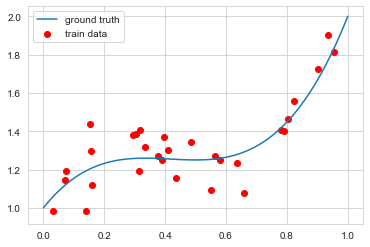

In [2]:
#
# The true polynomial relation:
# y(x) = 1 + 2x -5x^2 + 4x^3
#
# TODO: write down the proper coefficients
#


def powers_of_X(X, degree):
    powers = np.arange(degree + 1).reshape(1, -1)
    return X ** powers


def compute_polynomial(X, Theta):
    XP = np.array(powers_of_X(X, len(Theta) - 1)) * Theta.reshape(1,-1)
    Y = np.sum(XP, axis = 1).reshape(-1,1)
    return Y


true_poly_theta = np.array([1.0, 2.0, -5.0, 4.0])


def make_dataset(N, theta=true_poly_theta, sigma=0.1):
    """ Sample a dataset """
    X = np.random.uniform(size=(N, 1))
    Y_clean = compute_polynomial(X, theta)
    Y = Y_clean + np.random.randn(N, 1) * sigma
    return X, Y


train_data = make_dataset(30)
XX = np.linspace(0, 1, 100).reshape(-1, 1)
YY = compute_polynomial(XX, true_poly_theta)
plt.scatter(train_data[0], train_data[1], label="train data", color="r")
plt.plot(XX, compute_polynomial(XX, true_poly_theta), label="ground truth")
plt.legend(loc="upper left")

In [3]:
def poly_fit(data, degree, alpha):
    "Fit a polynomial of a given degree and weight decay parameter alpha"
    X = powers_of_X(data[0], degree)  # Matrix N x d
    Y = data[1].reshape(-1, 1)  # Matrix N x 1
    #
    # TODO: implement the closed-form solution for Theta
    #
    # Please note that np.linalg.inv may be numerically unstable.
    # It is better to use np.linalg.solve or even a QR decomposition.
    
    #use closed form solution from HOMEWORK 1
    # theta = (X.T @ X + alpha * Identity)^-1 X.T @ Y
    
    Theta = np.linalg.solve(X.T @ X + alpha * np.identity(len(X.T)), X.T @ Y)
    
    return Theta

In [23]:
num_test_samples = 100
num_train_samples = [30]
alphas = [0.0, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]
degrees = range(15)
num_repetitions = 30


# sample a single test dataset for all experiments
test_data = make_dataset(num_test_samples)
results = []

for (repetition, num_train, alpha, degree,) in itertools.product(
    range(num_repetitions), num_train_samples, alphas, degrees
):
    train_data = make_dataset(num_train)
    Theta = poly_fit(train_data, degree, alpha)
    train_err = np.mean((train_data[1] - compute_polynomial(train_data[0], Theta)) ** 2) 
    test_err = np.mean((test_data[1] - compute_polynomial(test_data[0], Theta)) ** 2) 
    results.append(
        {
            "repetition": repetition,
            "num_train": num_train,
            "alpha": alpha,
            "degree": degree,
            "dataset": "train",
            "err_rate": train_err,
        }
    )
    results.append(
        {
            "repetition": repetition,
            "num_train": num_train,
            "alpha": alpha,
            "degree": degree,
            "dataset": "test",
            "err_rate": test_err,
        }
    )
results_df = pd.DataFrame(results)
results_df.head()

,repetition,num_train,alpha,degree,dataset,err_rate
0,0,30,0.0,0,train,0.036311
1,0,30,0.0,0,test,0.036912
2,0,30,0.0,1,train,0.014532
3,0,30,0.0,1,test,0.019634
4,0,30,0.0,2,train,0.014349


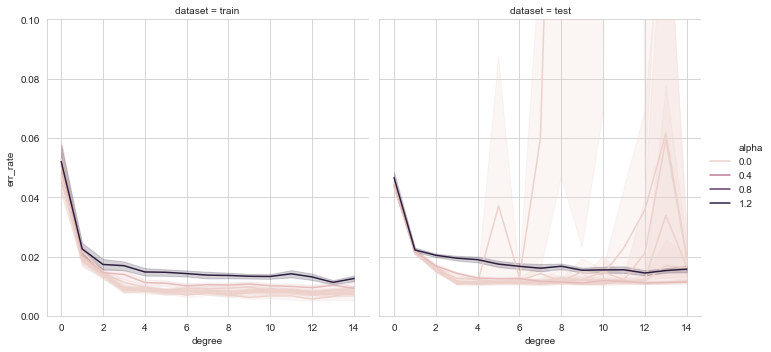

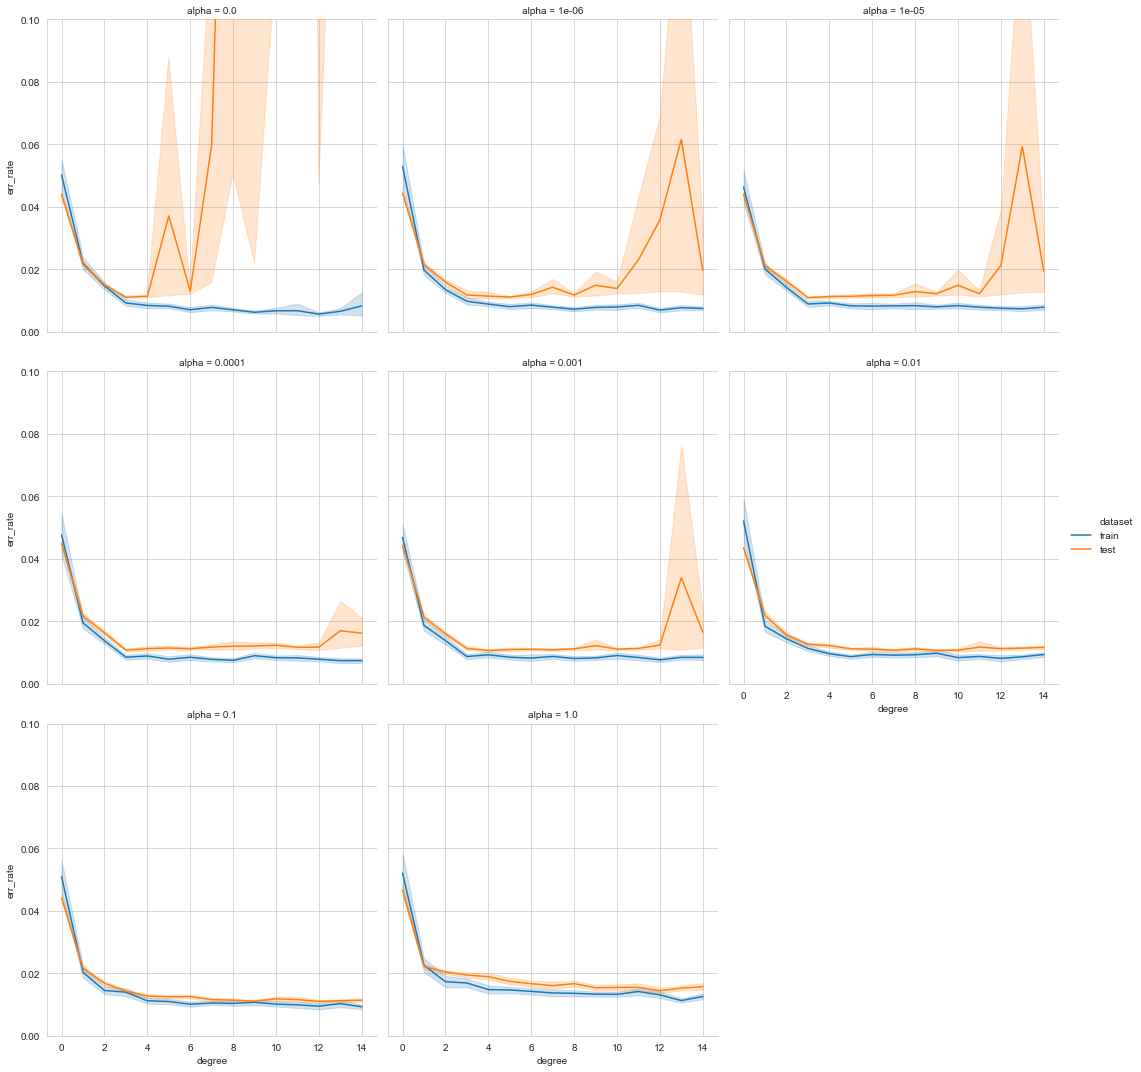

In [19]:
# TODO
#
# Plot how the error rates depend on the the polynomial degree and regularization
# constant.
# Try to find the best value for alpha on the test set, explain the model
# behaviour for small alphas and large alphas.
#
# Hint: the plots below all use sns.relplot!

graph_2 = sns.relplot(x='degree', y='err_rate', hue='alpha',
                col='dataset', kind = 'line', data = results_df)
graph_2.set(ylim = (0, 0.1))

graph_8 = sns.relplot(x='degree', y='err_rate', hue='dataset',
                col='alpha', kind = 'line',  data = results_df, col_wrap = 3)
graph_8.set(ylim = (0, 0.1))

**TODO**

Explain below the model behavoir for small alphas and large alphas.


- For alpha = 0, there is no regularization and we are left with ordinary polynomial fit, overfitting for high degree polynomial is very apparent. For small alphas, there is little regularizatin and the overfitting to the train set is still visible (test error increasing with degree of the model after reaching minimum) although less apparent, the test error initially decreases together with the train error and reaches a minimum value at degree = 3 (ie. our true degree of thepolynomial), but then goes up the terms have relatively small weights

- For big alphas, there seems to be little overfitting as the test error seems to be decreasing together with train error the weigths of the higher order terms are significant and the test error almost 'flattens out' in a similar fashion to the train error and we expect overfitting to take place - no minimum seems to be observed

## Task 2.2

In [24]:
#num_test_samples = 100
num_train_samples = [10, 15, 20, 25, 30, 35, 50, 60, 70, 80, 90, 100, 150, 200, 250, 350, 500, 600, 700, 800, 900, 1000]
alphas = [0.000001]
degrees = range(15)
num_repetitions = 30


# sample a single test dataset for all experiments
#test_data = make_dataset(num_test_samples)
results_2 = []

for (repetition, num_train, degree) in itertools.product(
    range(num_repetitions), num_train_samples, degrees
):
    train_data = make_dataset(num_train)
    Theta = poly_fit(train_data, degree, alphas)
    train_err = np.mean((train_data[1] - compute_polynomial(train_data[0], Theta)) ** 2)
    test_err = np.mean((test_data[1] - compute_polynomial(test_data[0], Theta)) ** 2)
    results_2.append(
        {
            "repetition": repetition,
            "num_train": num_train,
            "degree": degree,
            "dataset": "train",
            "err_rate": train_err,
        }
    )
    results_2.append(
        {
            "repetition": repetition,
            "num_train": num_train,
            "degree": degree,
            "dataset": "test",
            "err_rate": test_err,
        }
    )

results_df_2 = pd.DataFrame(results_2)
results_df_2.head()


,repetition,num_train,degree,dataset,err_rate
0,0,10,0,train,0.016567
1,0,10,0,test,0.036310
2,0,10,1,train,0.018292
3,0,10,1,test,0.030861
4,0,10,2,train,0.004445


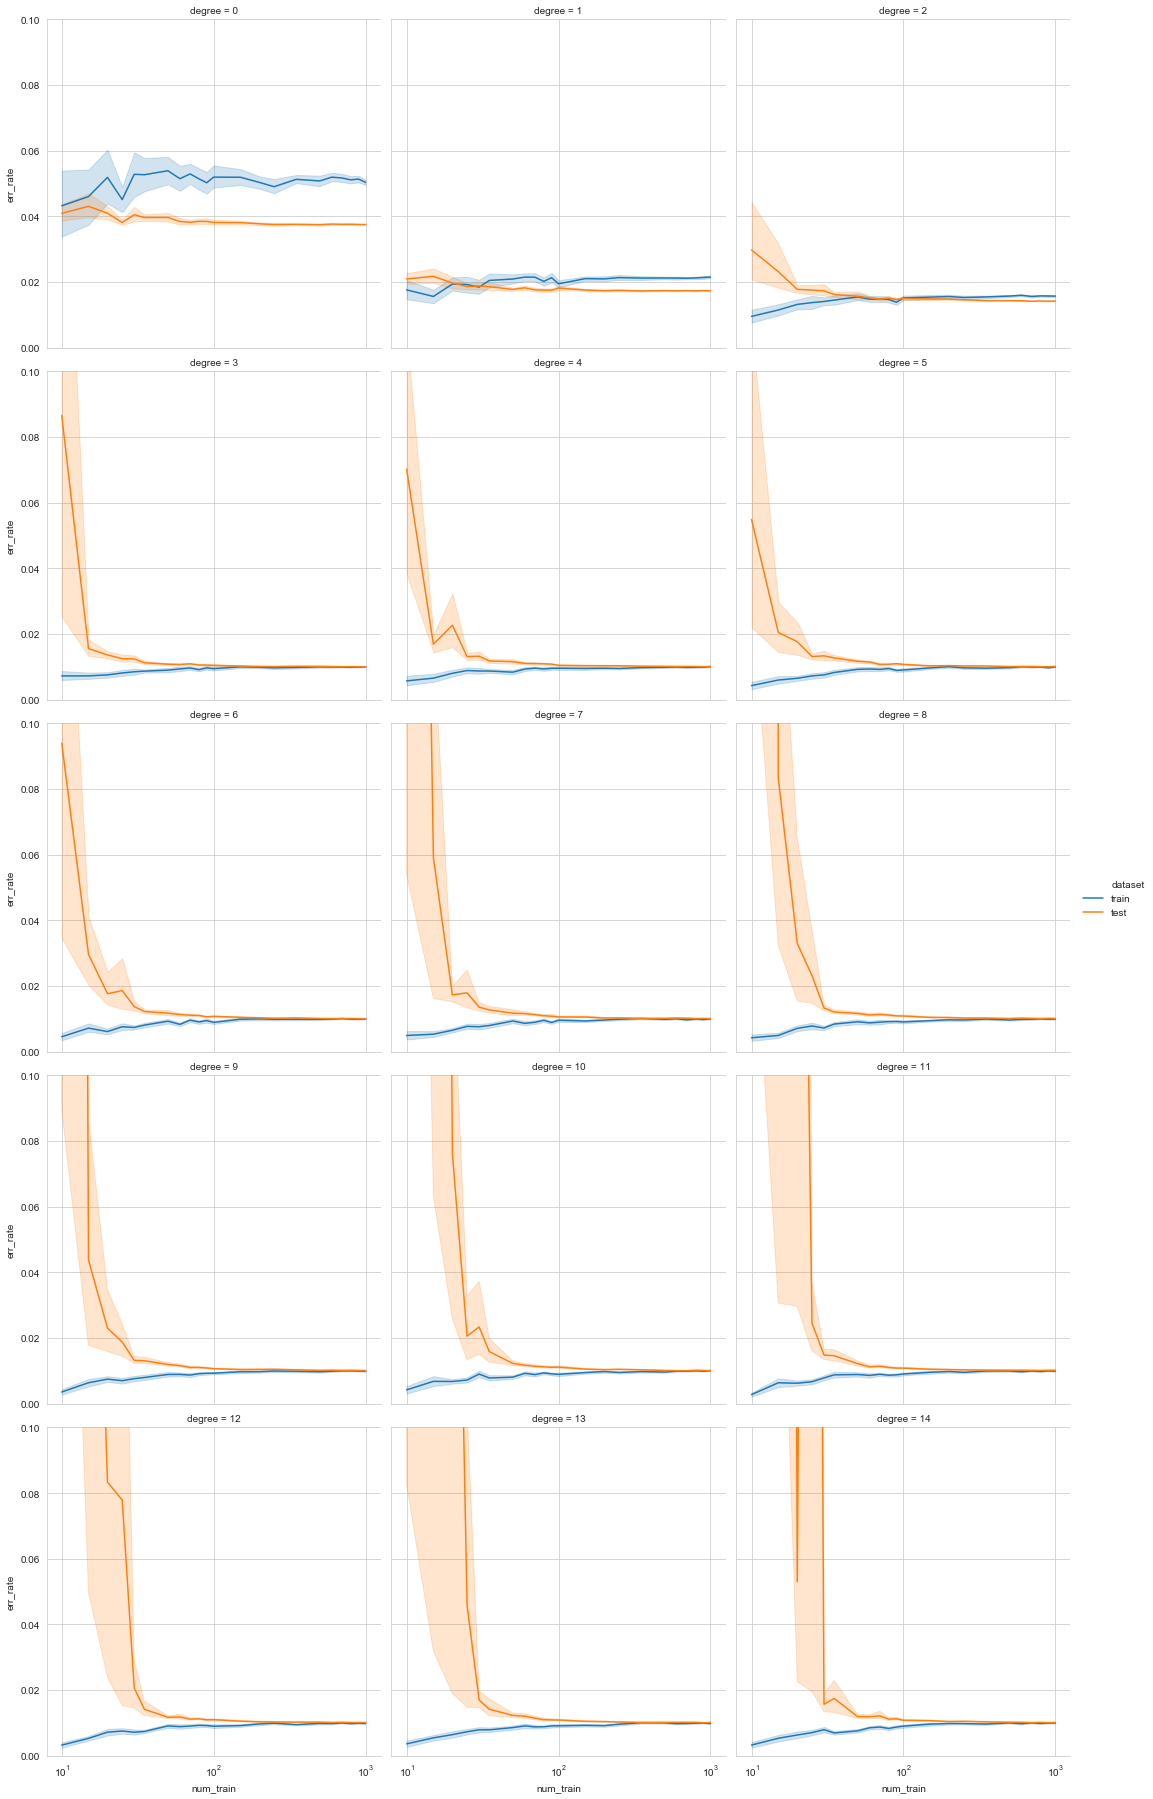

In [25]:
graph_15 = sns.relplot(x='num_train', y='err_rate', hue='dataset',
                col='degree', kind = 'line', data = results_df_2, col_wrap = 3)
graph_15.set(ylim = (0, 0.1))
plt.gca().set_xscale("log")

## SOMETIMES I GET CURVES WHERE THE ERR_RATES ARE BASICALLY IDENTICAL (OR TRAIN EVEN HIGHER) - IS THIS JUST AN UNFORTUNATE 
## RESULT OF A PARTICULAR RANDOM X & Y SAMPLING??

**TODO** Describe in two sentences the plot above. What can you notice?

- for degrees higher than the true degree the test set error decreases rapidly with increasing training test size, but the test and train error rates seem to flatten out after the trainsize gets roughly similar in size to the test set size. Further increasing the training set size does not reduce the error rate on the test set

In [30]:
## SOMETIMES I GET CURVES WHERE THE PLATEAU ERR_RATES ARE BASICALLY IDENTICAL (OR TRAIN EVEN HIGHER) - IS THIS JUST AN UNFORTUNATE 
## RESULT OF A PARTICULAR RANDOM X & Y SAMPLING??

## Task 2.3



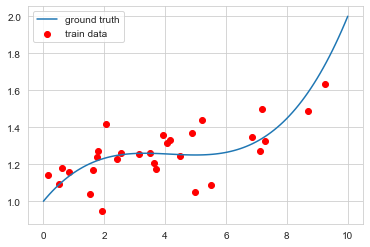

In [31]:
true_poly_theta_3 = np.array([1.0, 0.2, -0.05, 0.004])


def make_dataset_3(N, theta=true_poly_theta_3, sigma=0.1):
    """ Sample a dataset """
    X = np.random.uniform(low = 0, high = 10.0, size=(N, 1))
    Y_clean = compute_polynomial(X, theta)
    Y = Y_clean + np.random.randn(N, 1) * sigma
    return X, Y

train_data = make_dataset_3(30)
XX = np.linspace(0, 10, 100).reshape(-1, 1)
YY = compute_polynomial(XX, true_poly_theta_3)
plt.scatter(train_data[0], train_data[1], label="train data", color="r")
plt.plot(XX, compute_polynomial(XX, true_poly_theta_3), label="ground truth")
plt.legend(loc="upper left")

In [36]:
num_test_samples = 100
num_train_samples = [30]
alphas = [0.0, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]
degrees = range(15)
num_repetitions = 30

test_data = make_dataset_3(num_test_samples)
results_3 = []

for (repetition, num_train, alpha, degree,) in itertools.product(
    range(num_repetitions), num_train_samples, alphas, degrees
):
    train_data = make_dataset_3(num_train)
    Theta = poly_fit(train_data, degree, alpha)
    train_err = np.mean((train_data[1] - compute_polynomial(train_data[0], Theta)) ** 2)
    test_err = np.mean((test_data[1] - compute_polynomial(test_data[0], Theta)) ** 2)
    results_3.append(
        {
            "repetition": repetition,
            "num_train": num_train,
            "alpha": alpha,
            "degree": degree,
            "dataset": "train",
            "err_rate": train_err,
        }
    )
    results_3.append(
        {
            "repetition": repetition,
            "num_train": num_train,
            "alpha": alpha,
            "degree": degree,
            "dataset": "test",
            "err_rate": test_err,
        }
    )
results_df_3 = pd.DataFrame(results_3)
results_df_3.head()

,repetition,num_train,alpha,degree,dataset,err_rate
0,0,30,0.0,0,train,0.052281
1,0,30,0.0,0,test,0.040345
2,0,30,0.0,1,train,0.017678
3,0,30,0.0,1,test,0.018793
4,0,30,0.0,2,train,0.012719


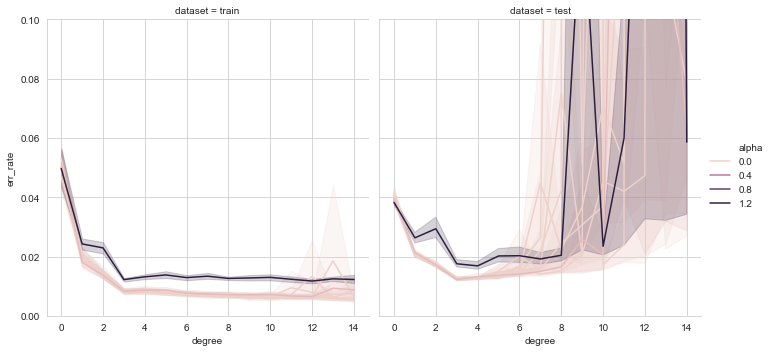

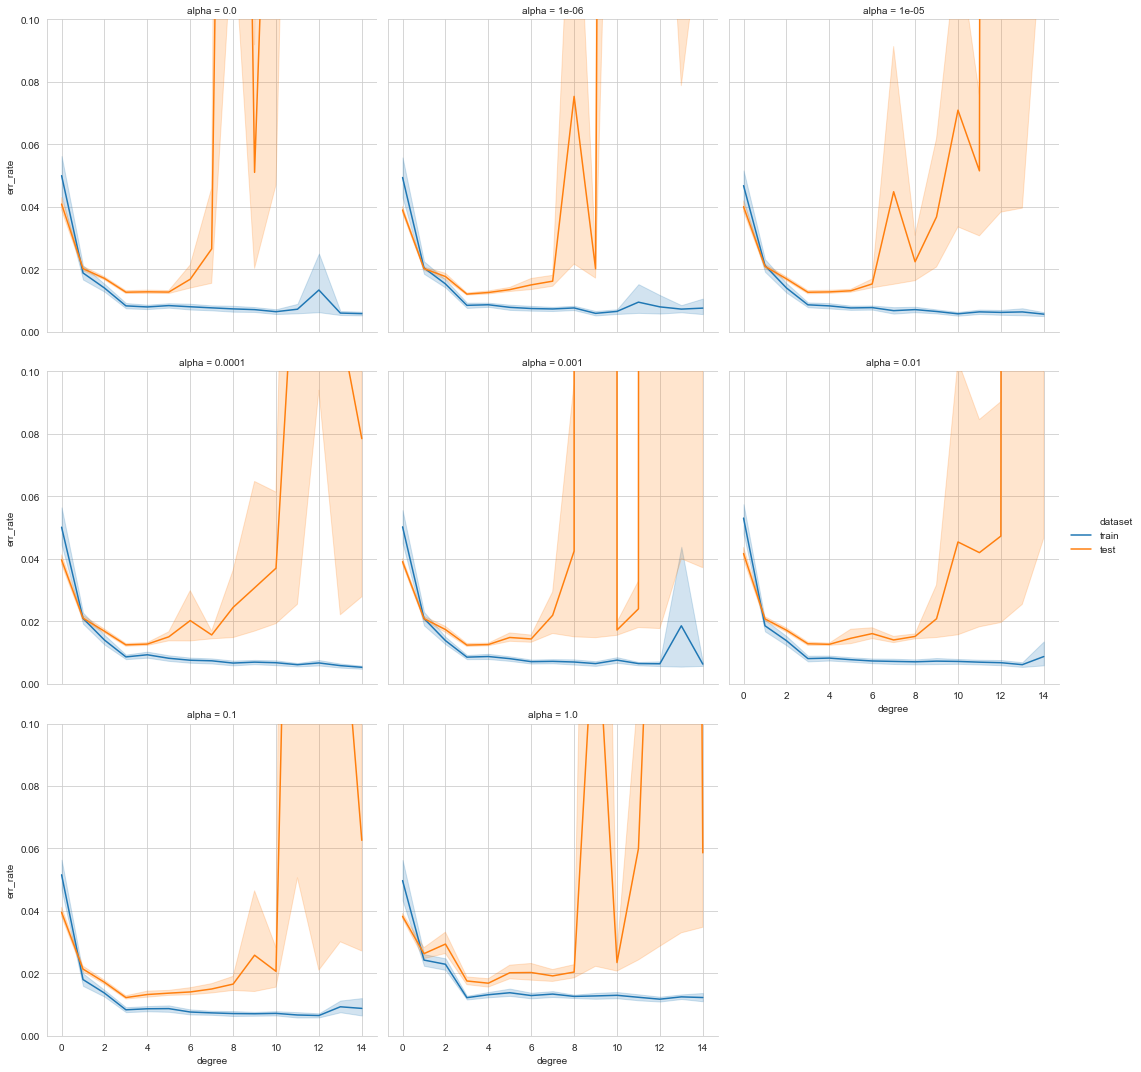

In [37]:
graph_2_3 = sns.relplot(x='degree', y='err_rate', hue='alpha',
                col='dataset', kind = 'line',  data = results_df_3)
graph_2_3.set(ylim = (0, 0.1))

graph_8_3 = sns.relplot(x='degree', y='err_rate', hue='dataset',
                col='alpha', kind = 'line',  data = results_df_3, col_wrap = 3)
graph_8_3.set(ylim = (0, 0.1))

**TODO** Answer below the questions:

Would it make sense to normalize the data after feature expansion?

- Yes it would, otherwise the high degree terms dominate over the small degree terms

Which dataset is easier to fit?

- The first dataset is easier to fit, in the second there is still overfitting despite using ridge regression

When is ridge regression most effective?

- Ridge regression is most effective when the ranges of the features are of similar size 

# Problem 3 [1p + 2bp] Numerical optimization

Implement the [Rosenborck function](https://en.wikipedia.org/wiki/Rosenbrock_function). Then find its optimum using the [`scipy.optimize.fmin_l_bfgs_b`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_l_bfgs_b.html).


In [118]:
#
# Implement the Rosenbrock function
#


def rosenbrock_v(x):
    """Returns the value of Rosenbrock's function at x"""
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2


def rosenbrock(x):
    """Returns the value of rosenbrock's function and its gradient at x
    """
    val = rosenbrock_v(x)
    #Gradient should be np.array
    dVdx = -2 + 2 * x[0] - 400 * x[0] * (x[1] - x[0]**2)
    dVdy = 200 * (x[1] - x[0]**2)
    grad_V = np.array([dVdx, dVdy])
    
    return [val, grad_V]


#
# Feel free to add your own test points.
#
for test_point in [[0.0, 0.0], [1.0, 1.0], [0.5, 1.0], [1.0, 0.5]]:
    assert check_gradient(rosenbrock, np.array(test_point), prec=1e-5)

(0, 2)

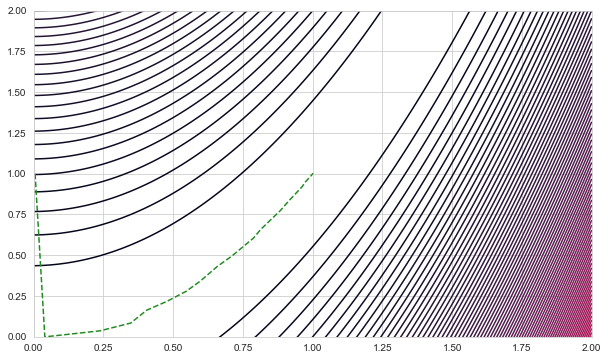

In [131]:
#
# Use scipy.optimize.fmin_l_bfgs_b
# Make a contour plot of the Rosenbrock function, plot the optimization path
# on the coutnour plot
#
# Hint: to save the points you can use the callback argument!
#

lbfsg_hist = []

x = np.arange(-2.0, 2.01, 0.01)

xx, yy  = np.meshgrid(x, x)

z = np.array([xx, yy]).reshape(2, -1)

values = rosenbrock_v(z)



def save_hist(x):
    lbfsg_hist.append(np.array(x))


x_start = [0.0, 2.0]

lbfsgb_ret = sopt.fmin_l_bfgs_b(rosenbrock, x_start, callback=save_hist)

opt_trac_x = [x[0] for x in lbfsg_hist]
opt_trac_y = [y[1] for y in lbfsg_hist]


# TODO: plot the countours of the function and overlay the optimization trajectory
plt.figure(figsize = (10,6))
plt.contour(xx, yy, values.reshape(xx.shape), 200)
plt.plot(opt_trac_x, opt_trac_y, c = 'forestgreen', ls = '--')
plt.xlim(0,2)
plt.ylim(0,2)


Tried step length: 1.000000, decrease: 399.994981, m: 799.994987, cond_value 79.999499
Accepted step length: 1.000000, new value: 1.005019
Tried step length: 1.000000, decrease: -99.495289, m: 2.007516, cond_value 0.200752
Tried step length: 0.500000, decrease: -5.528293, m: 2.007516, cond_value 0.100376
Tried step length: 0.250000, decrease: 0.046584, m: 2.007516, cond_value 0.050188
Tried step length: 0.125000, decrease: 0.210722, m: 2.007516, cond_value 0.025094
Accepted step length: 0.125000, new value: 0.794297
Tried step length: 1.000000, decrease: 0.149031, m: 0.421512, cond_value 0.042151
Accepted step length: 1.000000, new value: 0.645266
Tried step length: 1.000000, decrease: 0.284919, m: 0.494170, cond_value 0.049417
Accepted step length: 1.000000, new value: 0.360347
Tried step length: 1.000000, decrease: -0.739648, m: 0.384515, cond_value 0.038452
Tried step length: 0.500000, decrease: 0.091528, m: 0.384515, cond_value 0.019226
Accepted step length: 0.500000, new value: 0.

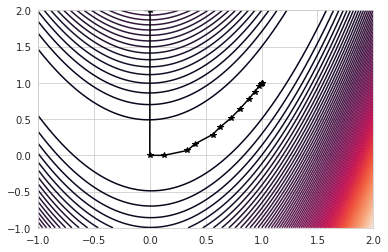

In [ ]:
#
# Bonus problem
#

# Newton-Raphson Method


def rosenbrock_hessian(x):
    # TODO: compute the value, gradient and Hessian of Rosenbrock's function'
        return [val, np.array((dvdx0, dvdx1)), H]


def Newton(f, Theta0, alpha, stop_tolerance=1e-10, max_steps=1000000):

    # TODO:
    #  - implement the newton method and a simple line search
    #  - make sure your function is resilient at critical points (such as seddle points)
    #  - if the Newton direction is not minimizing the function, use the gradient for a few steps
    #  - try to beat L-BFGS on the bmber of function evaluations needed!

        return Theta, history, fun_evals


Xopt, Xhist, fun_evals = Newton(
    rosenbrock_hessian, x_start, alpha=1e-0, stop_tolerance=1e-10, max_steps=1e6
)
Xhist_ = np.array([[x[0][0], x[0][1]] for x in Xhist])

print(
    "Found optimum at %s in %d steps (%d function evals)(true minimum is at [1,1])"
    % (Xopt, len(Xhist), fun_evals)
)

MX, MY = np.meshgrid(np.linspace(-1, 2, 100), np.linspace(-1, 2, 100))
Z = np.array([MX, MY]).reshape(2, -1)
VR = rosenbrock_v(Z)
plt.contour(MX, MY, VR.reshape(MX.shape), 100)
plt.plot(Xhist_[:, 0], Xhist_[:, 1], "*-k")

# Problem 4 (Logistic Regression) [2p]

Linear regression is suitable for problems, where
the forecasted values are real numbers. We use logistic regression,
when we want to label the data with $0$ and $1$.

Let $x\in \mathbb{R}^n$ be a row vector of $n$ real numbers, and
$y\in \{0,1\}$ the given class label. Similarly to what was shown
during the lecture, we add an additional element $x_0=1$
to vector $x$, to account for the bias term (and simplify the equations).

Similarly to linear regression, vector
$\Theta\in \mathbb{R}^{n+1}$ parametrizes the model
($n$ coefficients describes the data, the remaining one is the intercept).
In logistic regression, we model conditional probability that
sample $x$ belongs to class $1$ as:

\begin{equation}
p(\text{class}=1|x, \Theta)=h_\Theta(x) = \sigma\left(\sum_{j=0}^n  x_j\Theta_j\right) 
= \sigma\left(x\Theta \right),
\end{equation}

where $\sigma(a) = \frac{1}{1+\exp(-a)}$ is being called the logistic sigmoid
(a function, which plot is s-curved).

An unknown sample $x$ is being labeled $1$ if
$h_\Theta(x)\geq 0.5$, or equivalently, $x\Theta \geq 0$.

Classification mismatch between the forecasted values and
the data is being measured most of the time with cross-entropy:

\begin{equation}
    J(\Theta) = - \sum_{i=1}^m y^{(i)} \log \left(h_\Theta (x^{(i)})\right) + (1-y^{(i)}) \log \left(1-h_\Theta (x^{(i)})\right),
\end{equation}

assuming $0\log(0)=0$.


## Task 4.1 [1p]
Use logistic regression to distinguish
  _Versicolor_ and _Virginica_ irises. Use only the
  `petal length` and `petal width` features. Use either
  Gradient Descent, or L-BFGS to solve for the optimal $\Theta$.
  Prepare the scatterplot of the data and plot the class separation
  boundary found by logistic regression.

## Task 4.2 [1p]

In an analogy to Ridge Regression, implement a penalty on the weights of logistic regression. 

Then make a contour plot of the probability assigned by the model with no regularization $\alpha=0$ and with regularization, e.g. $\alpha=10^-2$ and $\alpha=1$. Describe what has changed?

## Task 4.1 solution

In [35]:
iris = datasets.load_iris()
print("Features: ", iris.feature_names)
print("Targets: ", iris.target_names)
petal_length = iris.data[:, iris.feature_names.index("petal length (cm)")].reshape(-1, 1)
petal_width = iris.data[:, iris.feature_names.index("petal width (cm)")].reshape(-1, 1)

Features:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Targets:  ['setosa' 'versicolor' 'virginica']


Text(0, 0.5, 'petal_width')

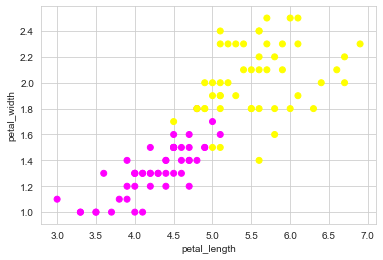

In [63]:
# Extract the petal_length and petal_width of versicolors and virginicas

IrisX = np.hstack([np.ones_like(petal_length), petal_length, petal_width])
IrisX = IrisX[iris.target != 0, :]

# Set versicolor=0 and virginia=1
IrisY = (iris.target[iris.target != 0] - 1).reshape(-1, 1).astype(np.float64)

plt.scatter(IrisX[:, 1], IrisX[:,2], c = IrisY.ravel(), cmap="spring")
plt.xlabel("petal_length")
plt.ylabel("petal_width")

(2.7951433691756273, 7.104856630824373)

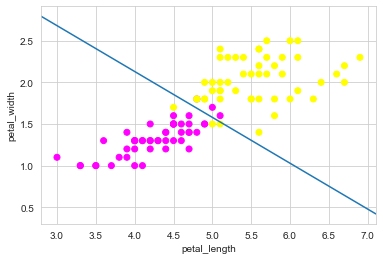

In [67]:
def logreg_loss(Theta, X, Y):
    #
    # Write a logistic regression cost suitable for use with fmin_l_bfgs
    #

    # reshape Theta into a column vector - lBFGS gives us a flat array
    ThetaR = Theta.reshape(X.shape[1], 1)
    
    #calculate probabilities beforehand for clearer code
    prob_1 = (1 / (1 + np.exp(-X @ ThetaR)))
    prob_0 = 1 - prob_1 #need to sum up to one
    
    nll = - np.sum(Y * np.log(prob_1) + (1 - Y) * np.log(prob_0))
    
    #grad = X.T (sigma(X Theta) - Y)
    grad = X.T @ (prob_1 - Y)

    # reshape grad into the shape of Theta, for fmin_l_bfsgb to work
    return nll, grad.reshape(Theta.shape)


Theta0 = np.zeros((3, ))

#
# Call a solver
#
ThetaOpt = sopt.fmin_l_bfgs_b(
    lambda Theta: logreg_loss(Theta, IrisX, IrisY), np.array(Theta0)
)[0]


#
# Now plot the found separation line
#

plt.scatter(IrisX[:, 1], IrisX[:, 2], c=IrisY.ravel(), cmap="spring")
plt.xlabel("petal_length")
plt.ylabel("petal_width")
pl_min, pl_max = plt.xlim()
pl = np.linspace(pl_min, pl_max, 1000)
plt.plot(pl, -(ThetaOpt[0] + ThetaOpt[1] * pl) / ThetaOpt[2])
plt.xlim(pl_min, pl_max)

## Task 4.2 solution

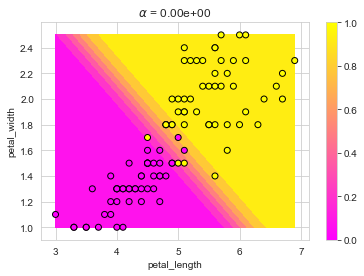

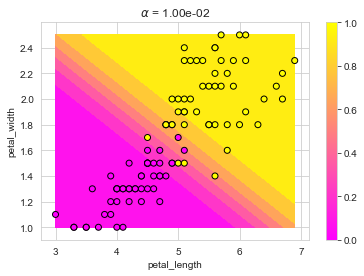

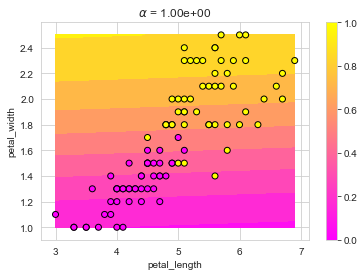

In [96]:
# Change logistic regression to include a weight penalty term as in ridge regression
# Then plot the probabilities for different values of alpha
# Hint: use the contour plot code from Assignent 1
alphas = [0, 1e-2, 1.0]

def logreg_loss_with_reg(Theta, X, Y, alpha=0.):
    #
    # Copy the logistic regression code and extend it with L2 regularization
    #
    
    ThetaR = Theta.reshape(X.shape[1], 1)
    
    #calculate probabilities beforehand for clearer code
    prob_1 = (1 / (1 + np.exp(-X @ ThetaR)))
    prob_0 = 1 - prob_1 #need to sum up to one
    
    nll = - np.sum(Y * np.log(prob_1) + (1 - Y) * np.log(prob_0)) + (alpha / 2) * ThetaR.T @ ThetaR
    
    #grad = X.T (sigma(X Theta) - Y)
    grad = X.T @ (prob_1 - Y) + alpha * ThetaR

    # reshape grad into the shape of Theta, for fmin_l_bfsgb to work
    return nll, grad.reshape(Theta.shape)


mesh_x, mesh_y = np.meshgrid(
    np.linspace(IrisX[:, 1].min(), IrisX[:, 1].max(), 100),
    np.linspace(IrisX[:, 2].min(), IrisX[:, 2].max(), 100),
)
mesh_data = np.hstack([np.ones(mesh_x.reshape(-1, 1).shape), mesh_x.reshape(-1, 1), mesh_y.reshape(-1, 1)])

for alpha in alphas:
    Theta0 = np.zeros((3, ))

    #
    # Call a solver
    #
    ThetaOpt, _, dic = sopt.fmin_l_bfgs_b(
        lambda Theta: logreg_loss_with_reg(Theta, IrisX, IrisY, alpha=alpha), np.array(Theta0)
    )
    
    # Now calculate probabilities for mesh_data
    probs = 1 / (1 + np.exp(-ThetaOpt @ mesh_data.T))


    # Plot the decision boundary
    #
    plt.contourf(mesh_x, mesh_y, probs.reshape(mesh_x.shape), cmap='spring')

    plt.scatter(IrisX[:, 1], IrisX[:, 2], c=IrisY.ravel(), cmap="spring", linewidths=1, edgecolors='black')
    plt.colorbar()
    plt.xlabel("petal_length")
    plt.ylabel("petal_width")
    pl_min, pl_max = plt.xlim()
    plt.title(fr'$\alpha$ = {alpha:.2e}')
    plt.xlim(pl_min, pl_max)
    plt.show()

**TODO**: type here what has change with the change of $\alpha$.

With increasing alpha, the decision boundary gets more horizontal (ie. the decision becomes more heavily influenced by the petal width and almost independent of the petal length at alpha = 1) and the probabilities 'smear out', ie. the boundary gets less sharp 

# Problem 5 (Quantile Regression) [4p]

  The least squares method results in estimates that approximate
  the conditional mean of the response variable given certain values
  of the predictor variables.  However, for many applications we are interested
  in a median or other percentile rather than the mean of the response
  variable. An approximation of a percentile can be achieved
  indirectly by using the least squares method to fit a model,
  assuming a gaussian distribution on residuals of this model and
  calculating the required percentile of the gaussian distribution.
  The problems with this commonly used technique appear when the
  distribution of residuals does not follow a gaussian distribution.

  The quantile regression
  (https://en.wikipedia.org/wiki/Quantile_regression) aims at
  directly estimating a value of the conditional percentile of the
  response variable. It is often use in e.g. sales forecasting, where
  we are interested in e.g. keeping enough items to have a 90% chance
  to cover the demand. In quantile regression, instead of minimizing the mean squared error,
  quantile regression minimizes a different cost function namely:
  \begin{equation}
  f_{\tau} = \left\{
    \begin{array}{rl}
      \tau\cdot x & \text{if } x \geq 0,\\
      -(1-\tau)\cdot x & \text{if } x < 0,
    \end{array} \right.
  \end{equation}
  where $\tau$ is the precentile of interest.


Download the house pricing data set from
    https://raw.githubusercontent.com/janchorowski/nn_assignments/nn18/assignment3/03-house-prices-outliers.csv. To
    load it into Python, you can use the `pandas.read_csv`
    function.

    This data contains information about areas and prices of around
    5000 houses offered for sale. Imagine you want to buy a 60 squared
    meters flat. How much money do you need to have to be able to
    choose between $75\%$ of all flats offered for sale?

1. **[1p]** Fit a linear regression model to the relation of a house price
    on its area using the least squares method. Plot a historgram of the
    residuals. Fit a Gaussian distribution to the residuals and overlay
    it on the histogram. Calculate the 75 percentile of
    this distribution (you can look it up in a percentile table, or
    use the `scipy.stats.norm.ppf` function). Check the goodness of fit
    of your model by calculating the ratio of prices below the
    estimated 75 percentile. 

    How many samples are within the confidence interval? Is it too large or too small?

2. **[1p]** Locate the outlying points and remove them from the dataset. Again check if the residuals look gaussian, and compute the 75th percentile.

3. **[1.5p]** Fit a quantile regression model to fill data by minimizing the $f_{\tau}$
    function. To fit the model write a function returning the cost,
    and its derivative (you can assume that the derivative is 0 at the
    singular points) suitable for use with the L-BFGS solver. You
    can start the solver from the least squares solution. Check the
    goodness of fit as described above.

    Now you can calculate the 75 percentile price value for a 60
    squared meters flat using the more adequate model. 

4. **[0.5p]** Again, remove the outlying points and refit quantile regression. How much did the solution change? Why?
    
**Note**: Technically, we can not use a gradient-based
    optimization method to minimize the $f_{\tau}$ loss because it
    doesn't have a derivative at $x=0$. One solution is to use a
    subgradient method
    https://en.wikipedia.org/wiki/Subderivative. It is also
    possible to use a smooth loss function -- common variants are the
    Huber loss (https://en.wikipedia.org/wiki/Huber_loss) or a
    variant of the smooth approximation to the absolute value
    $\text{abs}(x) \approx \sqrt{x^2+\epsilon}$ with a small
    $\epsilon$. However, just ignoring the singular points tends to
    work well in practice.


In [4]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/janchorowski/nn_assignments/nn18/assignment3/03-house-prices-outliers.csv",
    index_col=0,
)
data.head()

,rooms,area,price
0,3,66.80,367.801
1,3,55.03,289.458
2,4,70.80,389.000
3,1,29.02,195.695
4,2,45.76,265.754


In [5]:
X = np.stack((np.ones_like(data.area), data.area)).T
X

array([[ 1.  , 66.8 ],
       [ 1.  , 55.03],
       [ 1.  , 70.8 ],
       ...,
       [ 1.  , 46.7 ],
       [ 1.  , 50.41],
       [ 1.  , 48.1 ]])

In [6]:
Y = np.asarray(data.price)[:, None]
Y

array([[367.801],
       [289.458],
       [389.   ],
       ...,
       [266.   ],
       [267.1  ],
       [269.   ]])

In [7]:
least_squares_data = [X,Y]
least_squares_theta = poly_fit(least_squares_data, degree = 1., alpha = 0.)

In [13]:
residuals = (X @ least_squares_theta - Y).reshape(-1,1)
data['residuals'] = residuals

mean,std = sstats.norm.fit(residuals)

quant_25 = sstats.norm.ppf(0.25, loc = mean, scale = std)
quant_75 = sstats.norm.ppf(0.75, loc = mean, scale = std)
quants = [quant_25, quant_75]

(-300, 300)

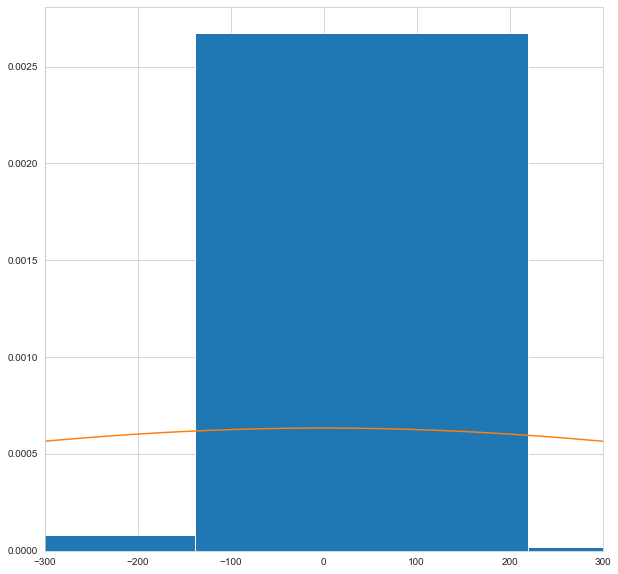

In [48]:
x = np.linspace(-3000, 3000, 5000)

plt.figure(figsize = (10,10))
plt.hist(residuals, bins = 100, density = True)

plt.plot(x, sstats.norm.pdf(x, mean, std))

# flat line if xlim is changed
plt.xlim(-300, 300)

In [39]:
# ratio of prices below the estimated 75 percentile.

ratio_above_75 = len(data['residuals'][data['residuals'] > quant_75]) / len(residuals)
ratio_below_25 = len(data['residuals'][data['residuals'] < quant_25]) / len(residuals)

In [36]:
print(f'Theta from Least squares: {least_squares_theta}')
print(f'Fraction of errs below 25 perc: {ratio_below_25}, above 75 perc: {ratio_above_75}')
print(f'Quantiles of normal distribution {quants}')

Theta from Least squares: [[-14.09901832]
 [  6.54132271]]
Fraction of errs below 25 perc: 0.0059121621621621625, above 75 perc: 0.00033783783783783786
Quantiles of normal distribution [-424.62839329897565, 424.6283932989754]


In [49]:
samples_in = len(data['residuals'][(data['residuals'] > quant_25) & (data['residuals'] < quant_75)])

print(f'The number of samples in the confidence interval is {samples_in}')
print(f'The total number of samples is {len(residuals)}')

The number of samples in the confidence interval is 5883
The total number of samples is 5920


Theta from Least squares: [[-14.09901832]
 [  6.54132271]]
Fraction of errs below 25 perc: 0.000338, above 75 perc: 0.005912
Quantiles of normal distribution: [-424.6283933  424.6283933]


Theta from Least squares on filtered data: [[-5.6329695 ]
 [ 6.20028843]]
Fraction of errs below 25 perc: 0.112050, above 75 perc: 0.095826
Quantiles of normal distribution: [-62.33395671  62.33395671]


Quant 25 theta [[20.6384748 ]
 [ 5.02348918]]
Fraction of negative errs: 0.250169 (should be 0.250000)
Quant 50 theta [[11.67491442]
 [ 5.76939273]]
Fraction of negative errs: 0.500000 (should be 0.500000)
Quant 75 theta [[0.11453587]
 [6.48799901]]
Fraction of negative errs: 0.746284 (should be 0.750000)


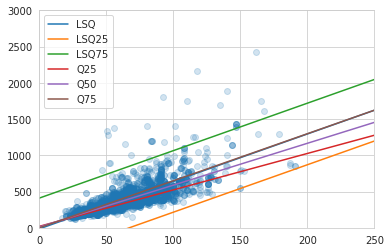

# Problem 6 [1-4bp]

Apply the [General Robust loss function](https://arxiv.org/abs/1701.03077) to the data from problem 5.

Grading: you will get one bonus point for implementing the loss without the prior and trying a few values of $\alpha$. Comparing and using  the provided implementation can give you another bonus point. Your own implementation of the adaptative variant gives 4 points.